# Modellbildung und Simulation - Übung 1

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pylab
import numpy.polynomial.polynomial as poly
accData = pd.read_csv("data/Acceleration.csv", sep=";")
pvData = pd.read_csv("data/Pressure_and_velocity.csv", sep=";")

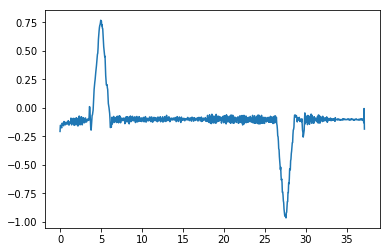

In [4]:
plt.plot(accData['Time (s)'], accData['Acceleration (m/s²)'])

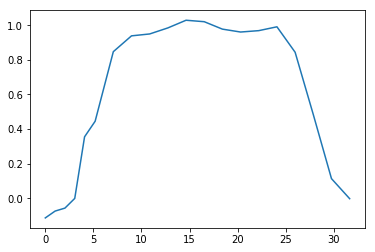

In [5]:
plt.plot(pvData['Time (s)'], pvData['Velocity (m/s)'])

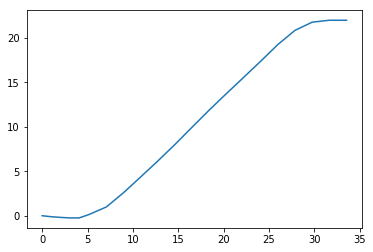

In [6]:
plt.plot(pvData['Time (s)'], pvData['Height (m)'])

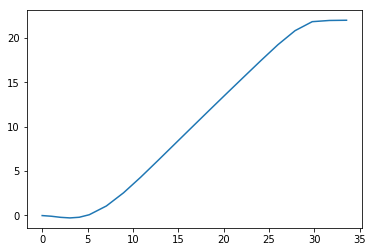

In [47]:
coefs = poly.polyfit(pvData['Time (s)'], pvData['Height (m)'], 10)
ffit = poly.Polynomial(coefs)    # instead of np.poly1d
plt.plot(pvData['Time (s)'], ffit(pvData['Time (s)']))

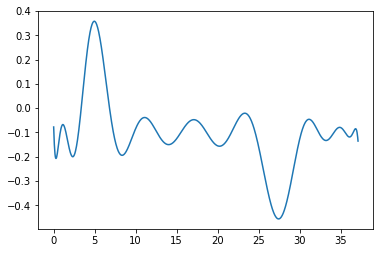

In [38]:
coefs = poly.polyfit(accData['Time (s)'], accData['Acceleration (m/s²)'], 17)
ffit = poly.Polynomial(coefs)    # instead of np.poly1d
plt.plot(accData['Time (s)'], ffit(accData['Time (s)']))